# MultiSensor Dataset Preparation 
- Experiment data: March 2024. Aluminum, Laser-Wire DED
- Aurthor: Chen Lequn

### Notebook 3b: Feature selection, ML modelling and ablation study (feature-based audio model)
- Full Dataset: All features (from previous notebook 2b)
- Ablated Dataset 1: Features after removing those with Pearson correlation > 0.97 (within audio modality).
- Ablated Dataset 2: Features after removing those with Pearson correlation > 0.9 (within audio modality).
- Ablated Dataset 3: Features from Ablated Dataset 1 with MI > 0.05.
- Ablated Dataset 4: Features from Ablated Dataset 1 with MI > 0.1.

In [1]:
import os
import glob
import sys
import math
import numpy as np
import pandas as pd
from IPython.core.display import display, HTML
from pandas import DataFrame
import scipy as sp
import itertools
from collections import defaultdict
from pprint import pprint
import pickle

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
from pylab import *
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline

# Scikit-learn general
from sklearn import preprocessing, metrics, svm, datasets, tree, neighbors
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, scale
from sklearn.ensemble import HistGradientBoostingClassifier

# Scikit-learn models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, SVR
from sklearn.multiclass import OneVsRestClassifier

# Imbalanced learn
from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier

# XGBoost and LightGBM
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Utilities
from scipy.stats import uniform, randint
from scipy.interpolate import griddata
from sklearn.utils import shuffle, resample, class_weight
from utils import *
from joblib import dump, load
np.random.seed(0)

/tmp/ipykernel_359271/2296993266.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
def display_left_wide(df, column_width=800):
    # Adjust the max column width
    pd.set_option('display.max_colwidth', column_width)

    # Display the dataframe on the left with custom column width
    left_aligned_df = '<div style="float: left;">{}</div>'.format(df.to_html())
    display(HTML(left_aligned_df))

In [3]:
PROJECT_ROOT_DIR = "../"

IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'defect classification', 'ML-baseline', 'ablation study')
model_path = os.path.join(PROJECT_ROOT_DIR, "trained_models", 'defect classification', 'ML-baseline', 'ablation study')
scaler_path = os.path.join(PROJECT_ROOT_DIR, "saved_scalers", 'defect classification',  'ML-baseline', 'ablation study')
os.makedirs(IMAGE_PATH, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
os.makedirs(scaler_path, exist_ok=True)

# Change to desirable location of the raw dataset
Multimodal_dataset_PATH = "/home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset"
Annotation_file_path = os.path.join(Multimodal_dataset_PATH, "Annotation")
Dataset_path = os.path.join(Multimodal_dataset_PATH, 'Dataset')
final_audio_dataset = os.path.join(Multimodal_dataset_PATH, 'Dataset', "audio")
final_image_dataset = os.path.join(Multimodal_dataset_PATH, 'Dataset', "thermal_images")
              

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

In [4]:
%store -r train_indices
%store -r val_indices
%store -r test_indices

In [5]:
val_indices

array([1877, 2514, 2861, 3311,  146, 1772, 3135,  981, 2176, 1578, 2738,
        713,  388, 3138, 1862, 1445, 2671, 3463, 1630, 1808, 1504, 1382,
       1745, 3427, 2049,  392, 1816, 3426,  984, 1952,  885,   76, 1221,
       2518, 2281, 1850, 1498, 3056,   78, 1515, 2682, 2076, 2621,  511,
       1384,  228, 2291, 1845, 1602,  957, 1457, 1368, 3303,  244, 3488,
       3482, 1852, 1765, 2462, 2730,  373,  695, 1512,  107, 2476, 1331,
       3284, 1050, 2391,  139,  891, 1351, 1408, 2691, 2632, 1694,  135,
       2261, 2032,  723, 1849, 1959, 1350, 2247,   69, 2842, 2659, 1837,
        317, 1543, 1381, 1246, 1010,  308,  725,  493, 2485, 3089, 2617,
       3058,  381, 1003, 3119, 2870, 2134,  211,   42, 1757,  699, 2604,
       1696,  335, 2341, 1724, 3076, 2921, 2692, 1909, 3441, 1851, 1622,
       3356,  735,  341, 3211, 1242, 3204, 2433, 2448,  574, 1617,   21,
       2824, 2019, 3409, 1707, 2060, 2127, 2571, 3380, 2189, 1402, 2519,
       3112, 2535, 2180,  834, 2554, 3268,  793,  8

## Load Dataset

In [6]:
%store -r datasets
%store -r le
%store -r Y_encoded

In [7]:
datasets

{'All Features': array([[ 5.53998351e-02,  6.33679852e-02,  1.41814817e-02, ...,
          6.66273212e+00, -8.07054901e+00,  8.54411411e+00],
        [ 3.73191573e-02,  4.78442460e-02,  1.36817107e-02, ...,
          8.28698635e+00, -1.24810438e+01,  8.78491020e+00],
        [ 2.83142067e-02,  3.07730399e-02,  1.30546829e-02, ...,
          6.42625332e+00, -1.35510588e+01,  6.35541964e+00],
        ...,
        [ 1.22464793e-02,  1.48045355e-02,  5.10020321e-03, ...,
          6.38746643e+00, -1.07345905e+01,  8.09787750e+00],
        [ 1.33671844e-02,  1.65460929e-02,  5.38443821e-03, ...,
          4.76326370e+00, -1.38471327e+01,  7.91168976e+00],
        [ 1.29805105e-02,  1.56615954e-02,  5.63964201e-03, ...,
          5.72218609e+00, -1.30503092e+01,  7.41869259e+00]]),
 'Ablated 1': array([[ 1.41814817e-02,  2.15419494e-02, -3.66150551e+01, ...,
          6.66273212e+00, -8.07054901e+00,  8.54411411e+00],
        [ 1.36817107e-02,  5.73696159e-02, -3.72269363e+01, ...,
         

In [8]:
class_weights_encoded = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(Y_encoded),
                                                 y = Y_encoded)


class_names = (le.classes_).tolist()
print(f"class weights encoded: {class_weights_encoded}")
print(f"class        : {class_names}")

class weights encoded: [ 1.33638095  1.30505952 20.88095238  0.85083677 14.31836735  0.38938839
  0.61565462]
class        : ['Balling (Conduction)', 'Balling (LoF)', 'Balling (Overheating)', 'Laser-off', 'LoF', 'Non-defective', 'Overheating']


In [9]:
# List of models
model_names = ['KNN', 'DT', 'RF', 'BalancedRF', 'RUSBoost', 'Ada', 'NN', 'XGBoost', 'LightGBM', 'SVM', 'HistGB']

### Basic Evaluation Metrics


In [10]:
from joblib import dump, load
def evaluate_saved_models(model_path, datasets, kf, model_names, Y_encoded, train_indices, val_indices, test_indices, le, n_runs=10):
    """
    Load and evaluate pre-trained models.

    Parameters:
    - model_path (str): Directory where the pre-trained models are saved.
    - datasets (dict): Dictionary containing the names of datasets as keys and features as values.
    - kf (KFold): KFold cross-validator.
    - model_names (list): List of model names to evaluate.
    - Y_encoded (array): Array of encoded labels.
    - train_indices (array): Indices for training set.
    - val_indices (array): Indices for validation set.
    - test_indices (array): Indices for test set.
    - le (LabelEncoder): Pre-fitted LabelEncoder for class names.
    - n_runs (int): Number of runs to measure inference time.

    Returns:
    - final_results_df (DataFrame): DataFrame containing evaluation metrics.
    """
    # Create a dictionary to store final results
    final_results = defaultdict(list)
    
    # Create a dictionary to store temporary cross-validation results for each dataset and model
    cv_results = defaultdict(lambda: defaultdict(list))

    # Iterate over datasets and models
    for dataset_name, X in datasets.items():
        print(f"Processing dataset: {dataset_name}")
        
        # Split data
        X_train, X_val, X_test = X[train_indices], X[val_indices], X[test_indices]
        y_train, y_val, y_test = Y_encoded[train_indices], Y_encoded[val_indices], Y_encoded[test_indices]
        
        # Scaling
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)
        
        # Load the model
        for model_name in model_names:
            print(f"Evaluating model: {model_name}")
            
            model_file = os.path.join(model_path, f"{model_name}_{dataset_name}.joblib")
            model = load(model_file)

            #### -------Loop through all models and measure inference time----------###
            # Initialize metrics for inference time
            inference_times = []
            times = []
            X_val_subset = X_val[:1000]
            for _ in range(n_runs):
                start_time = time.perf_counter()
                predictions = model.predict(X_val_subset)
                end_time = time.perf_counter()
                times.append(end_time - start_time)
            # Calculate average and standard deviation
            avg_time = np.mean(times)
            std_time = np.std(times)

            print(f"Inference Time: Mean = {avg_time:.6f} milliseconds, Std = {std_time:.6} milliseconds")
            cv_results[dataset_name][f"{model_name}_Inference Time_mean"] = avg_time
            cv_results[dataset_name][f"{model_name}_Inference Time_std"] = std_time
            ####-------Loop through all models and measure inference time----------###

            
            ###-------Confusion matrix: lass-specific accuracy-------------####
            # Initialize metrics for class-specific accuracy
            class_accuracies = defaultdict(list)
            # Calculate class-specific accuracies
            y_test_pred = model.predict(X_test)
            cm = confusion_matrix(y_test, y_test_pred)
            class_acc = cm.diagonal() / cm.sum(axis=1)
            for i, acc in enumerate(class_acc):
                class_name = le.inverse_transform([i])[0]  # Convert encoded class to original string name
                class_accuracies[class_name].append(acc)            
                
            # Calculate mean and std for class-specific accuracies
            for class_name, accuracies in class_accuracies.items():
                mean_acc = np.mean(accuracies)
                std_acc = np.std(accuracies)
                cv_results[dataset_name][f"{model_name}_{class_name}_mean"] = mean_acc
                cv_results[dataset_name][f"{model_name}_{class_name}_std"] = std_acc
                # Print the mean and std for the accuracy of the class "Keyhole pores" if it exists
                if class_name == "Balling":
                    print(f"Class 'Balling': Accuracy Mean = {mean_acc}, Std = {std_acc}")
                elif class_name == "Non-defective":
                    print(f"Class 'Non-defective': Accuracy Mean = {mean_acc}, Std = {std_acc}")
                elif class_name == "Laser-off":
                    print(f"Class 'Laser-off': Accuracy Mean = {mean_acc}, Std = {std_acc}")
            ###-------Confusion matrix: lass-specific accuracy-------------####
                    
            ###-------------5-fold cross-validation -----------
            # Initialize fold metrics
            fold_metrics = defaultdict(list)
            for train_idx, test_idx in kf.split(X_test):
                X_test_train, X_test_val = X_test[train_idx], X_test[test_idx]
                y_test_train, y_test_val = y_test[train_idx], y_test[test_idx]
                
                # Make predictions
                y_test_pred = model.predict(X_test_val)

                # Calculate metrics
                acc = accuracy_score(y_test_val, y_test_pred)
                f1 = f1_score(y_test_val, y_test_pred, average='weighted')
                precision = precision_score(y_test_val, y_test_pred, average='weighted')
                recall = recall_score(y_test_val, y_test_pred, average='weighted')

                try:
                    roc_auc = roc_auc_score(y_test_val, model.predict_proba(X_test_val), multi_class='ovr', average='weighted')
                except:
                    roc_auc = 'N/A'

                # Store the metrics for this fold
                fold_metrics['Accuracy'].append(acc)
                fold_metrics['F1 Score'].append(f1)
                fold_metrics['Precision'].append(precision)
                fold_metrics['Recall'].append(recall)
                fold_metrics['ROC-AUC'].append(roc_auc if roc_auc != 'N/A' else np.nan)
                    
            # -------Calculate mean and std for each metric------------
            for metric, values in fold_metrics.items():
                mean_val = np.nanmean(values)
                std_val = np.nanstd(values)
                print(f"{metric}: Mean = {mean_val}, Std = {std_val}")
                cv_results[dataset_name][f"{model_name}_{metric}_mean"] = mean_val
                cv_results[dataset_name][f"{model_name}_{metric}_std"] = std_val

    
    # Convert the temporary results to the final format
    for dataset_name, metrics in cv_results.items():
        final_results['Dataset'].append(dataset_name)
        for metric_name, value in metrics.items():
            final_results[metric_name].append(value)
    
    # Convert results to a DataFrame
    final_results_df = pd.DataFrame(final_results)

    return final_results_df

In [11]:
# Initialize KFold with the number of splits you desire
kf = KFold(n_splits=5)
final_results_df = evaluate_saved_models(model_path, datasets, kf, model_names, Y_encoded, train_indices, val_indices, test_indices, le, n_runs=20)

Processing dataset: All Features
Evaluating model: KNN
Inference Time: Mean = 0.006074 milliseconds, Std = 0.0132439 milliseconds
Class 'Laser-off': Accuracy Mean = 0.864406779661017, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.9767441860465116, Std = 0.0


/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy: Mean = 0.8459959758551309, Std = 0.04587341589747742
F1 Score: Mean = 0.822358305444322, Std = 0.0487096067009983
Precision: Mean = 0.8353375578448503, Std = 0.04719406176792067
Recall: Mean = 0.8459959758551309, Std = 0.04587341589747742
ROC-AUC: Mean = 0.9935544481887302, Std = 0.0
Evaluating model: DT
Inference Time: Mean = 0.000056 milliseconds, Std = 1.71328e-05 milliseconds
Class 'Laser-off': Accuracy Mean = 0.6779661016949152, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.8992248062015504, Std = 0.0
Accuracy: Mean = 0.8174647887323943, Std = 0.058516296999397865
F1 Score: Mean = 0.8126729246897249, Std = 0.059489607661439216
Precision: Mean = 0.8183233539882323, Std = 0.06180881473688094
Recall: Mean = 0.8174647887323943, Std = 0.058516296999397865
ROC-AUC: Mean = 0.9467805812274371, Std = 0.0
Evaluating model: RF
Inference Time: Mean = 0.000806 milliseconds, Std = 0.000341824 milliseconds
Class 'Laser-off': Accuracy Mean = 0.9322033898305084, Std = 0.0
Class 'Non

/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anacon

Inference Time: Mean = 0.010256 milliseconds, Std = 0.000239385 milliseconds
Class 'Laser-off': Accuracy Mean = 0.7457627118644068, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.8372093023255814, Std = 0.0
Accuracy: Mean = 0.7519919517102616, Std = 0.060801433257112694
F1 Score: Mean = 0.771817660580224, Std = 0.05728089771600894
Precision: Mean = 0.8081239467230624, Std = 0.05244249062254717
Recall: Mean = 0.7519919517102616, Std = 0.060801433257112694
ROC-AUC: Mean = 0.9597207012118752, Std = 0.0
Evaluating model: Ada


/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anacon

Inference Time: Mean = 0.015097 milliseconds, Std = 0.000456913 milliseconds
Class 'Laser-off': Accuracy Mean = 0.847457627118644, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.8992248062015504, Std = 0.0
Accuracy: Mean = 0.8204828973843059, Std = 0.047563349597128754
F1 Score: Mean = 0.8197377415526755, Std = 0.05291804245567844
Precision: Mean = 0.8398825067175167, Std = 0.06295980158390688
Recall: Mean = 0.8204828973843059, Std = 0.047563349597128754
ROC-AUC: Mean = 0.9738150504926961, Std = 0.0
Evaluating model: NN
Inference Time: Mean = 0.000648 milliseconds, Std = 7.08833e-05 milliseconds
Class 'Laser-off': Accuracy Mean = 0.847457627118644, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.9534883720930233, Std = 0.0
Accuracy: Mean = 0.8974647887323943, Std = 0.03970805450848535
F1 Score: Mean = 0.8997330247600404, Std = 0.03869290974403047
Precision: Mean = 0.9115765163743031, Std = 0.036878327919252864
Recall: Mean = 0.8974647887323943, Std = 0.03970805450848535
ROC-AUC:

/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequ

Inference Time: Mean = 0.003638 milliseconds, Std = 0.0118597 milliseconds
Class 'Laser-off': Accuracy Mean = 0.9322033898305084, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.9689922480620154, Std = 0.0
Accuracy: Mean = 0.91158953722334, Std = 0.03197602833161758
F1 Score: Mean = 0.9014335521144364, Std = 0.03628970415279016
Precision: Mean = 0.9106594927984204, Std = 0.03343769338371674
Recall: Mean = 0.91158953722334, Std = 0.03197602833161758
ROC-AUC: Mean = 0.9946166925268131, Std = 0.0
Evaluating model: LightGBM
Inference Time: Mean = 0.001218 milliseconds, Std = 0.00222168 milliseconds
Class 'Laser-off': Accuracy Mean = 0.9322033898305084, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.9844961240310077, Std = 0.0
Accuracy: Mean = 0.9002012072434609, Std = 0.04346504934538363
F1 Score: Mean = 0.8877246341539827, Std = 0.0461782361495026
Precision: Mean = 0.9018844908007899, Std = 0.045367183070708875
Recall: Mean = 0.9002012072434609, Std = 0.04346504934538363
ROC-AUC: M

/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Inference Time: Mean = 0.005105 milliseconds, Std = 0.000207442 milliseconds
Class 'Laser-off': Accuracy Mean = 0.3728813559322034, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.2248062015503876, Std = 0.0
Accuracy: Mean = 0.35887323943661975, Std = 0.020913787126921084
F1 Score: Mean = 0.3787396793499189, Std = 0.04112585433941231
Precision: Mean = 0.5370009822676153, Std = 0.13751636766627387
Recall: Mean = 0.35887323943661975, Std = 0.020913787126921084
ROC-AUC: Mean = 0.6104491964130745, Std = 0.0
Processing dataset: Ablated 1
Evaluating model: KNN
Inference Time: Mean = 0.001323 milliseconds, Std = 0.000128275 milliseconds
Class 'Laser-off': Accuracy Mean = 0.8305084745762712, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.9689922480620154, Std = 0.0
Accuracy: Mean = 0.8488531187122736, Std = 0.03828871810700505
F1 Score: Mean = 0.8291431137544851, Std = 0.04268893757996784
Precision: Mean = 0.8335800081748582, Std = 0.04388736895334594
Recall: Mean = 0.8488531187122736, 

/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Inference Time: Mean = 0.006189 milliseconds, Std = 0.000225524 milliseconds
Class 'Laser-off': Accuracy Mean = 0.7966101694915254, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.8914728682170543, Std = 0.0
Accuracy: Mean = 0.772112676056338, Std = 0.050936932063273044
F1 Score: Mean = 0.7783384366498798, Std = 0.05003916298706093
Precision: Mean = 0.8245299484413376, Std = 0.04526916864354303
Recall: Mean = 0.772112676056338, Std = 0.050936932063273044
ROC-AUC: Mean = 0.9733066057130971, Std = 0.0
Evaluating model: RUSBoost


/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Inference Time: Mean = 0.010343 milliseconds, Std = 0.000363159 milliseconds
Class 'Laser-off': Accuracy Mean = 0.7966101694915254, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.8372093023255814, Std = 0.0
Accuracy: Mean = 0.7548490945674043, Std = 0.06518202981681442
F1 Score: Mean = 0.763929409390275, Std = 0.057409540422977134
Precision: Mean = 0.7909292637011629, Std = 0.05274578496810403
Recall: Mean = 0.7548490945674043, Std = 0.06518202981681442
ROC-AUC: Mean = 0.9635622268099815, Std = 0.0
Evaluating model: Ada


/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Inference Time: Mean = 0.015049 milliseconds, Std = 0.000491393 milliseconds
Class 'Laser-off': Accuracy Mean = 0.8305084745762712, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.8914728682170543, Std = 0.0
Accuracy: Mean = 0.8233400402414487, Std = 0.037989291657805874
F1 Score: Mean = 0.8190567635459074, Std = 0.04169073477007435
Precision: Mean = 0.8252060103437528, Std = 0.0523874201571081
Recall: Mean = 0.8233400402414487, Std = 0.037989291657805874
ROC-AUC: Mean = 0.9764215950868186, Std = 0.0
Evaluating model: NN
Inference Time: Mean = 0.000754 milliseconds, Std = 0.000481582 milliseconds
Class 'Laser-off': Accuracy Mean = 0.8813559322033898, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.9612403100775194, Std = 0.0
Accuracy: Mean = 0.9172635814889336, Std = 0.04381689544901273
F1 Score: Mean = 0.91879337817417, Std = 0.041216601533066444
Precision: Mean = 0.9266223652642165, Std = 0.03582882119036206
Recall: Mean = 0.9172635814889336, Std = 0.04381689544901273
ROC-AUC: 

/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/

Inference Time: Mean = 0.006891 milliseconds, Std = 0.00779632 milliseconds
Class 'Laser-off': Accuracy Mean = 0.8813559322033898, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.9689922480620154, Std = 0.0
Accuracy: Mean = 0.8974245472837022, Std = 0.024617243711320416
F1 Score: Mean = 0.8900636138038639, Std = 0.028187462612737885
Precision: Mean = 0.8913232907151591, Std = 0.02733584641736531
Recall: Mean = 0.8974245472837022, Std = 0.024617243711320416
ROC-AUC: Mean = 0.9913899565686302, Std = 0.0
Evaluating model: LightGBM
Inference Time: Mean = 0.000686 milliseconds, Std = 5.44188e-05 milliseconds
Class 'Laser-off': Accuracy Mean = 0.9322033898305084, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.9767441860465116, Std = 0.0
Accuracy: Mean = 0.9002012072434609, Std = 0.043465049345383616
F1 Score: Mean = 0.8898238390452418, Std = 0.04720177161505455
Precision: Mean = 0.8957913476327877, Std = 0.04474367140200297
Recall: Mean = 0.9002012072434609, Std = 0.043465049345383616

/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Inference Time: Mean = 0.005428 milliseconds, Std = 0.000457869 milliseconds
Class 'Laser-off': Accuracy Mean = 0.7288135593220338, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.6201550387596899, Std = 0.0
Accuracy: Mean = 0.39899396378269614, Std = 0.05353307683416525
F1 Score: Mean = 0.32731334152536096, Std = 0.05567036534933077
Precision: Mean = 0.29605086240991085, Std = 0.05235761675063874
Recall: Mean = 0.39899396378269614, Std = 0.05353307683416525
ROC-AUC: Mean = 0.590638024820374, Std = 0.0
Processing dataset: Ablated 2
Evaluating model: KNN
Inference Time: Mean = 0.001240 milliseconds, Std = 7.0474e-05 milliseconds
Class 'Laser-off': Accuracy Mean = 0.7966101694915254, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.9689922480620154, Std = 0.0
Accuracy: Mean = 0.8402414486921529, Std = 0.05098402566614448
F1 Score: Mean = 0.8182359035957516, Std = 0.06317458099232703
Precision: Mean = 0.8234350826066292, Std = 0.06665966809791259
Recall: Mean = 0.8402414486921529, St

/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/

Inference Time: Mean = 0.006118 milliseconds, Std = 0.000195296 milliseconds
Class 'Laser-off': Accuracy Mean = 0.7966101694915254, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.8449612403100775, Std = 0.0
Accuracy: Mean = 0.7720724346076459, Std = 0.054973324462313365
F1 Score: Mean = 0.790108034080674, Std = 0.049256939252437466
Precision: Mean = 0.8272248825154958, Std = 0.04643084663264137
Recall: Mean = 0.7720724346076459, Std = 0.054973324462313365
ROC-AUC: Mean = 0.9733285815063445, Std = 0.0
Evaluating model: RUSBoost


/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anacon

Inference Time: Mean = 0.010030 milliseconds, Std = 0.000336745 milliseconds
Class 'Laser-off': Accuracy Mean = 0.5423728813559322, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.9224806201550387, Std = 0.0
Accuracy: Mean = 0.7548893360160965, Std = 0.050209879776525065
F1 Score: Mean = 0.7396516672189428, Std = 0.059196361020149794
Precision: Mean = 0.752620767562356, Std = 0.05076470836639997
Recall: Mean = 0.7548893360160965, Std = 0.050209879776525065
ROC-AUC: Mean = 0.9438069852053461, Std = 0.0
Evaluating model: Ada


/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Inference Time: Mean = 0.014407 milliseconds, Std = 0.000427383 milliseconds
Class 'Laser-off': Accuracy Mean = 0.847457627118644, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.8914728682170543, Std = 0.0
Accuracy: Mean = 0.8033400402414488, Std = 0.04491774946332907
F1 Score: Mean = 0.790947584786329, Std = 0.046836755182091884
Precision: Mean = 0.80294499742377, Std = 0.05909676744352139
Recall: Mean = 0.8033400402414488, Std = 0.04491774946332907
ROC-AUC: Mean = 0.9741257124248633, Std = 0.0
Evaluating model: NN
Inference Time: Mean = 0.000620 milliseconds, Std = 6.10421e-05 milliseconds
Class 'Laser-off': Accuracy Mean = 0.864406779661017, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.9612403100775194, Std = 0.0
Accuracy: Mean = 0.8917102615694166, Std = 0.03575773705004218
F1 Score: Mean = 0.8870873797148615, Std = 0.03817842533214599
Precision: Mean = 0.8932450363557003, Std = 0.036998717728933456
Recall: Mean = 0.8917102615694166, Std = 0.03575773705004218
ROC-AUC: Mea

/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Inference Time: Mean = 0.008850 milliseconds, Std = 0.00577938 milliseconds
Class 'Laser-off': Accuracy Mean = 0.864406779661017, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.9534883720930233, Std = 0.0
Accuracy: Mean = 0.8745674044265593, Std = 0.036791029192930355
F1 Score: Mean = 0.8659734948341458, Std = 0.03944523546093064
Precision: Mean = 0.8711323103434003, Std = 0.036254152008551165
Recall: Mean = 0.8745674044265593, Std = 0.036791029192930355
ROC-AUC: Mean = 0.9917879512531026, Std = 0.0
Evaluating model: LightGBM
Inference Time: Mean = 0.000640 milliseconds, Std = 4.79026e-05 milliseconds
Class 'Laser-off': Accuracy Mean = 0.8983050847457628, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.9767441860465116, Std = 0.0
Accuracy: Mean = 0.8974647887323943, Std = 0.03970805450848535
F1 Score: Mean = 0.8880301019499635, Std = 0.044769829788008135
Precision: Mean = 0.8950357082369156, Std = 0.04175732948931538
Recall: Mean = 0.8974647887323943, Std = 0.03970805450848535
R

/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Inference Time: Mean = 0.005214 milliseconds, Std = 0.000241673 milliseconds
Class 'Laser-off': Accuracy Mean = 0.06779661016949153, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.49612403100775193, Std = 0.0
Accuracy: Mean = 0.34466800804828973, Std = 0.038113134723664316
F1 Score: Mean = 0.3309161923210516, Std = 0.03531946399850459
Precision: Mean = 0.45097032855858393, Std = 0.06793878884972356
Recall: Mean = 0.34466800804828973, Std = 0.038113134723664316
ROC-AUC: Mean = 0.5831781988157582, Std = 0.0
Processing dataset: Ablated 3
Evaluating model: KNN
Inference Time: Mean = 0.001153 milliseconds, Std = 0.000132738 milliseconds
Class 'Laser-off': Accuracy Mean = 0.8813559322033898, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.9612403100775194, Std = 0.0
Accuracy: Mean = 0.8631388329979879, Std = 0.045946043018186715
F1 Score: Mean = 0.8472052882720387, Std = 0.052166497498297756
Precision: Mean = 0.8490552024735175, Std = 0.05818434642542363
Recall: Mean = 0.8631388329979

/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequ

Inference Time: Mean = 0.006269 milliseconds, Std = 0.00011378 milliseconds
Class 'Laser-off': Accuracy Mean = 0.7966101694915254, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.8294573643410853, Std = 0.0
Accuracy: Mean = 0.7663581488933602, Std = 0.014874863813323945
F1 Score: Mean = 0.7849204029441346, Std = 0.014494862547601586
Precision: Mean = 0.8333929638436679, Std = 0.03530697245541081
Recall: Mean = 0.7663581488933602, Std = 0.014874863813323945
ROC-AUC: Mean = 0.9713599785183772, Std = 0.0
Evaluating model: RUSBoost


/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anacon

Inference Time: Mean = 0.009889 milliseconds, Std = 0.000335835 milliseconds
Class 'Laser-off': Accuracy Mean = 0.559322033898305, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.813953488372093, Std = 0.0
Accuracy: Mean = 0.7177464788732394, Std = 0.0690648545298257
F1 Score: Mean = 0.7394641004184391, Std = 0.06363299981470139
Precision: Mean = 0.789057429999408, Std = 0.06020159867491222
Recall: Mean = 0.7177464788732394, Std = 0.0690648545298257
ROC-AUC: Mean = 0.9578438069818217, Std = 0.0
Evaluating model: Ada


/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Inference Time: Mean = 0.013850 milliseconds, Std = 0.000404775 milliseconds
Class 'Laser-off': Accuracy Mean = 0.8305084745762712, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.8914728682170543, Std = 0.0
Accuracy: Mean = 0.7948490945674045, Std = 0.05763674119382228
F1 Score: Mean = 0.7888586122403346, Std = 0.05881934715559066
Precision: Mean = 0.8001562703000152, Std = 0.07195190402541468
Recall: Mean = 0.7948490945674045, Std = 0.05763674119382228
ROC-AUC: Mean = 0.9561521466589114, Std = 0.0
Evaluating model: NN
Inference Time: Mean = 0.000616 milliseconds, Std = 6.15657e-05 milliseconds
Class 'Laser-off': Accuracy Mean = 0.8983050847457628, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.9612403100775194, Std = 0.0
Accuracy: Mean = 0.9144869215291751, Std = 0.028674679534671746
F1 Score: Mean = 0.9084083415257111, Std = 0.03135589957734481
Precision: Mean = 0.9087438125627261, Std = 0.02994516554294387
Recall: Mean = 0.9144869215291751, Std = 0.028674679534671746
ROC-AUC

/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/

Inference Time: Mean = 0.009370 milliseconds, Std = 0.00388728 milliseconds
Class 'Laser-off': Accuracy Mean = 0.8135593220338984, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.9767441860465116, Std = 0.0
Accuracy: Mean = 0.8688531187122737, Std = 0.042972026521189026
F1 Score: Mean = 0.859263562993533, Std = 0.04729889952865252
Precision: Mean = 0.859928423404471, Std = 0.0499306960317889
Recall: Mean = 0.8688531187122737, Std = 0.042972026521189026
ROC-AUC: Mean = 0.9914453312050637, Std = 0.0
Evaluating model: LightGBM
Inference Time: Mean = 0.000842 milliseconds, Std = 0.000418185 milliseconds
Class 'Laser-off': Accuracy Mean = 0.8813559322033898, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.9767441860465116, Std = 0.0
Accuracy: Mean = 0.8859557344064386, Std = 0.043492312865780716
F1 Score: Mean = 0.8747883565188402, Std = 0.05110750406144029
Precision: Mean = 0.8753989760502752, Std = 0.05555345900124468
Recall: Mean = 0.8859557344064386, Std = 0.043492312865780716
ROC

/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Inference Time: Mean = 0.005436 milliseconds, Std = 0.000142219 milliseconds
Class 'Laser-off': Accuracy Mean = 0.6440677966101694, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.7984496124031008, Std = 0.0
Accuracy: Mean = 0.5413682092555332, Std = 0.056155582709580446
F1 Score: Mean = 0.5097585485494731, Std = 0.06683942588816931
Precision: Mean = 0.5134130407450327, Std = 0.06136530255512984
Recall: Mean = 0.5413682092555332, Std = 0.056155582709580446
ROC-AUC: Mean = 0.7182524923917614, Std = 0.0
Processing dataset: Ablated 4
Evaluating model: KNN
Inference Time: Mean = 0.001153 milliseconds, Std = 0.00011969 milliseconds
Class 'Laser-off': Accuracy Mean = 0.9152542372881356, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.9767441860465116, Std = 0.0
Accuracy: Mean = 0.8746478873239436, Std = 0.0481333820124745
F1 Score: Mean = 0.858960088075859, Std = 0.05316212074714894
Precision: Mean = 0.8641503535187904, Std = 0.05743782719070817
Recall: Mean = 0.8746478873239436, Std =

/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequ

Inference Time: Mean = 0.006187 milliseconds, Std = 0.000246232 milliseconds
Class 'Laser-off': Accuracy Mean = 0.8135593220338984, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.8604651162790697, Std = 0.0
Accuracy: Mean = 0.7692555331991952, Std = 0.06209366372233867
F1 Score: Mean = 0.7862438579190654, Std = 0.0573328723295353
Precision: Mean = 0.8315660499908715, Std = 0.04975749291612865
Recall: Mean = 0.7692555331991952, Std = 0.06209366372233867
ROC-AUC: Mean = 0.9722992751266436, Std = 0.0
Evaluating model: RUSBoost


/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anacon

Inference Time: Mean = 0.009400 milliseconds, Std = 0.000276989 milliseconds
Class 'Laser-off': Accuracy Mean = 0.8305084745762712, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.9147286821705426, Std = 0.0
Accuracy: Mean = 0.7890543259557344, Std = 0.04322193862902234
F1 Score: Mean = 0.7838494235494572, Std = 0.05133917526916134
Precision: Mean = 0.8045555363482928, Std = 0.05603228300636146
Recall: Mean = 0.7890543259557344, Std = 0.04322193862902234
ROC-AUC: Mean = 0.9662064382908101, Std = 0.0
Evaluating model: Ada


/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Inference Time: Mean = 0.013506 milliseconds, Std = 0.000343599 milliseconds
Class 'Laser-off': Accuracy Mean = 0.8813559322033898, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.8604651162790697, Std = 0.0
Accuracy: Mean = 0.7806036217303823, Std = 0.05764236016265111
F1 Score: Mean = 0.7722313886115032, Std = 0.06350959598121378
Precision: Mean = 0.7879168232657185, Std = 0.07064870205245506
Recall: Mean = 0.7806036217303823, Std = 0.05764236016265111
ROC-AUC: Mean = 0.9582892951489683, Std = 0.0
Evaluating model: NN
Inference Time: Mean = 0.000606 milliseconds, Std = 6.1096e-05 milliseconds
Class 'Laser-off': Accuracy Mean = 0.8813559322033898, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.937984496124031, Std = 0.0
Accuracy: Mean = 0.9088933601609657, Std = 0.029171969586878923
F1 Score: Mean = 0.9081095403498649, Std = 0.02888285290212723
Precision: Mean = 0.9150372333312327, Std = 0.027485713372810125
Recall: Mean = 0.9088933601609657, Std = 0.029171969586878923
ROC-AUC:

/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Inference Time: Mean = 0.007756 milliseconds, Std = 0.0082675 milliseconds
Class 'Laser-off': Accuracy Mean = 0.8983050847457628, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.9534883720930233, Std = 0.0
Accuracy: Mean = 0.8603621730382294, Std = 0.052300416158546886
F1 Score: Mean = 0.8511493368440842, Std = 0.054568953777604415
Precision: Mean = 0.8515703152558196, Std = 0.055113191202520125
Recall: Mean = 0.8603621730382294, Std = 0.052300416158546886
ROC-AUC: Mean = 0.9901703796772481, Std = 0.0
Evaluating model: LightGBM
Inference Time: Mean = 0.001212 milliseconds, Std = 0.00165381 milliseconds
Class 'Laser-off': Accuracy Mean = 0.8813559322033898, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.9612403100775194, Std = 0.0
Accuracy: Mean = 0.8688531187122737, Std = 0.04002120817959021
F1 Score: Mean = 0.8594281338845556, Std = 0.04568740414088298
Precision: Mean = 0.8624050466359232, Std = 0.04436936053704398
Recall: Mean = 0.8688531187122737, Std = 0.04002120817959021
RO

/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Inference Time: Mean = 0.005271 milliseconds, Std = 0.000224873 milliseconds
Class 'Laser-off': Accuracy Mean = 0.7457627118644068, Std = 0.0
Class 'Non-defective': Accuracy Mean = 0.6434108527131783, Std = 0.0
Accuracy: Mean = 0.6096177062374245, Std = 0.06138956649178364
F1 Score: Mean = 0.6001962536156503, Std = 0.06025342485759008
Precision: Mean = 0.6249071422070285, Std = 0.06036608609315611
Recall: Mean = 0.6096177062374245, Std = 0.06138956649178364
ROC-AUC: Mean = 0.7706874709060074, Std = 0.0


/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/working_primary/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/

In [12]:
final_results_df

,Dataset,KNN_Inference Time_mean,KNN_Inference Time_std,KNN_Balling (Conduction)_mean,KNN_Balling (Conduction)_std,KNN_Balling (LoF)_mean,KNN_Balling (LoF)_std,KNN_Balling (Overheating)_mean,KNN_Balling (Overheating)_std,KNN_Laser-off_mean,...,HistGB_Accuracy_mean,HistGB_Accuracy_std,HistGB_F1 Score_mean,HistGB_F1 Score_std,HistGB_Precision_mean,HistGB_Precision_std,HistGB_Recall_mean,HistGB_Recall_std,HistGB_ROC-AUC_mean,HistGB_ROC-AUC_std
0,All Features,0.006074,0.013244,0.368421,0.0,0.684211,0.0,0.0,0.0,0.864407,...,0.358873,0.020914,0.378740,0.041126,0.537001,0.137516,0.358873,0.020914,0.610449,0.0
1,Ablated 1,0.001323,0.000128,0.473684,0.0,0.684211,0.0,0.0,0.0,0.830508,...,0.398994,0.053533,0.327313,0.055670,0.296051,0.052358,0.398994,0.053533,0.590638,0.0
2,Ablated 2,0.001240,0.000070,0.473684,0.0,0.657895,0.0,0.0,0.0,0.796610,...,0.344668,0.038113,0.330916,0.035319,0.450970,0.067939,0.344668,0.038113,0.583178,0.0
3,Ablated 3,0.001153,0.000133,0.578947,0.0,0.657895,0.0,0.0,0.0,0.881356,...,0.541368,0.056156,0.509759,0.066839,0.513413,0.061365,0.541368,0.056156,0.718252,0.0
4,Ablated 4,0.001153,0.000120,0.578947,0.0,0.657895,0.0,0.0,0.0,0.915254,...,0.609618,0.061390,0.600196,0.060253,0.624907,0.060366,0.609618,0.061390,0.770687,0.0


In [13]:
print (final_results_df.columns)

Index(['Dataset', 'KNN_Inference Time_mean', 'KNN_Inference Time_std',
       'KNN_Balling (Conduction)_mean', 'KNN_Balling (Conduction)_std',
       'KNN_Balling (LoF)_mean', 'KNN_Balling (LoF)_std',
       'KNN_Balling (Overheating)_mean', 'KNN_Balling (Overheating)_std',
       'KNN_Laser-off_mean',
       ...
       'HistGB_Accuracy_mean', 'HistGB_Accuracy_std', 'HistGB_F1 Score_mean',
       'HistGB_F1 Score_std', 'HistGB_Precision_mean', 'HistGB_Precision_std',
       'HistGB_Recall_mean', 'HistGB_Recall_std', 'HistGB_ROC-AUC_mean',
       'HistGB_ROC-AUC_std'],
      dtype='object', length=287)


In [14]:
final_results_df.to_hdf(os.path.join(model_path, 'traditional_ML_evaluation_results.h5'), key='df', mode='w', format='table')

In [15]:
%store final_results_df

Stored 'final_results_df' (DataFrame)


In [16]:
final_results_df.to_csv(os.path.join(model_path, 'traditional_ML_evaluation_results.csv'), index=False)

## Evaluating inference time, file size, etc.

In [17]:
# Initialize the dictionary
model_paths = {}

# Generate the paths
for dataset_name in datasets:
    for model_name in model_names:
        file_name = f"{model_name}_{dataset_name}.joblib"
        full_path = os.path.join(model_path, file_name)
        model_paths[f"{model_name}_{dataset_name}"] = full_path

In [18]:
dataset_names = final_results_df['Dataset'].unique().tolist()
dataset_names

['All Features', 'Ablated 1', 'Ablated 2', 'Ablated 3', 'Ablated 4']

In [19]:
def plot_model_sizes(paths, fontsize=14):
    model_sizes = {}
    for name, path in paths.items():
        model_sizes[name] = os.path.getsize(path) // 1024  # Size in KB

    sorted_model_sizes = {k: v for k, v in sorted(model_sizes.items(), key=lambda item: item[1])}

    plt.figure(figsize=(10, 6))
    plt.barh(list(sorted_model_sizes.keys()), list(sorted_model_sizes.values()), 
             color='skyblue', edgecolor='black', linewidth=0.5)
    plt.xlabel('Model Size (KB)', fontsize=fontsize+6, labelpad=10)
    plt.ylabel('Model', fontsize=fontsize+6)
    plt.xticks(fontsize=fontsize, rotation=45, ha='right')
    plt.yticks(fontsize=fontsize)
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    # plt.show()

# Example usage:
# plot_model_sizes(model_paths)
# save_fig("model size comparisons")

## Final results presentation

In [21]:
# Modify the evaluation metrics to include class-specific accuracies
evaluation_metrics = ['Accuracy', 'F1 Score', 'Recall', 'Precision', 'ROC-AUC', 'Inference Time', 
                      'Balling (Conduction)', 'Balling (LoF)', 'Balling (Overheating)', 'Laser-off', 'LoF', 'Non-defective', 'Overheating']

In [22]:
def create_formatted_summary_table(df, metrics, top_n=3, selected_datasets=None, ranking_metric="Accuracy_mean"):
    # Initialize an empty DataFrame for the summary
    summary_df = pd.DataFrame(columns=['Dataset', 'Rank', 'Top Model', 'Model Size (KB)'] + metrics)

    # Calculate model sizes
    model_sizes = {}
    for name_path_key, path in model_paths.items():
        model_name, dataset_name = name_path_key.split('_')
        if dataset_name in selected_datasets:
            model_sizes[name_path_key] = os.path.getsize(path) // 1024  # Size in KB
    
    # Filter the DataFrame based on selected datasets if provided
    if selected_datasets is not None:
        df = df[df['Dataset'].isin(selected_datasets)]
    
    # Extract the model names from the columns
    model_names = set(col.split('_')[0] for col in df.columns if '_' in col)
    
    # Determine the order for sorting based on the ranking metric
    reverse_order = True  # Default is descending order
    if ranking_metric in ['Inference Time_mean', 'Model Size (KB)']:
        reverse_order = False  # For these metrics, smaller values are better
    
    # For each dataset, find the top N models based on the specified ranking metric and populate the summary table
    for i, row in df.iterrows():
        dataset = row['Dataset']
        scores = {}
        for model in model_names:
            metric_value = row.get(f"{model}_{ranking_metric}", np.nan)
            scores[model] = metric_value
        
        # Sort the models by the specified ranking metric and take the top N
        top_n_models = sorted(scores, key=scores.get, reverse=reverse_order)[:top_n]
        
        
        # Populate the summary table for this dataset and top N models
        for rank, model in enumerate(top_n_models, start=1):
            name_path_key = f"{model}_{dataset}"
            summary_row = {'Dataset': dataset, 'Rank': rank, 'Top Model': model, 'Model Size (KB)': model_sizes.get(name_path_key, 'N/A')}
            for metric in metrics:
                mean_val = row.get(f"{model}_{metric}_mean", np.nan) * 100  # Convert to percentage
                std_val = row.get(f"{model}_{metric}_std", np.nan) * 100  # Convert to percentage
                if not np.isnan(mean_val) and not np.isnan(std_val):
                    summary_row[metric] = f"{mean_val:.2f} ± {std_val:.4f}"  # Combine mean and std
                else:
                    summary_row[metric] = 'N/A'
                
            summary_df = summary_df.append(summary_row, ignore_index=True)
    
    return summary_df

# Create an example formatted summary table with top 3 models and all datasets
formatted_summary_df = create_formatted_summary_table(final_results_df, evaluation_metrics, top_n=3, selected_datasets=dataset_names, ranking_metric="Accuracy_mean")
formatted_summary_df

,Dataset,Rank,Top Model,Model Size (KB),Accuracy,F1 Score,Recall,Precision,ROC-AUC,Inference Time,Balling (Conduction),Balling (LoF),Balling (Overheating),Laser-off,LoF,Non-defective,Overheating
0,All Features,1,XGBoost,2664,91.16 ± 3.1976,90.14 ± 3.6290,91.16 ± 3.1976,91.07 ± 3.3438,99.46 ± 0.0000,0.36 ± 1.1860,68.42 ± 0.0000,78.95 ± 0.0000,0.00 ± 0.0000,93.22 ± 0.0000,75.00 ± 0.0000,96.90 ± 0.0000,100.00 ± 0.0000
1,All Features,2,LightGBM,712,90.02 ± 4.3465,88.77 ± 4.6178,90.02 ± 4.3465,90.19 ± 4.5367,99.32 ± 0.0000,0.12 ± 0.2222,57.89 ± 0.0000,73.68 ± 0.0000,0.00 ± 0.0000,93.22 ± 0.0000,75.00 ± 0.0000,98.45 ± 0.0000,100.00 ± 0.0000
2,All Features,3,NN,2867,89.75 ± 3.9708,89.97 ± 3.8693,89.75 ± 3.9708,91.16 ± 3.6878,99.37 ± 0.0000,0.06 ± 0.0071,68.42 ± 0.0000,86.84 ± 0.0000,100.00 ± 0.0000,84.75 ± 0.0000,100.00 ± 0.0000,95.35 ± 0.0000,95.06 ± 0.0000
3,Ablated 1,1,NN,2814,91.73 ± 4.3817,91.88 ± 4.1217,91.73 ± 4.3817,92.66 ± 3.5829,99.39 ± 0.0000,0.08 ± 0.0482,78.95 ± 0.0000,89.47 ± 0.0000,50.00 ± 0.0000,88.14 ± 0.0000,100.00 ± 0.0000,96.12 ± 0.0000,95.06 ± 0.0000
4,Ablated 1,2,LightGBM,866,90.02 ± 4.3465,88.98 ± 4.7202,90.02 ± 4.3465,89.58 ± 4.4744,99.80 ± 0.0000,0.07 ± 0.0054,65.79 ± 0.0000,71.05 ± 0.0000,0.00 ± 0.0000,93.22 ± 0.0000,75.00 ± 0.0000,97.67 ± 0.0000,98.77 ± 0.0000
5,Ablated 1,3,XGBoost,2672,89.74 ± 2.4617,89.01 ± 2.8187,89.74 ± 2.4617,89.13 ± 2.7336,99.14 ± 0.0000,0.69 ± 0.7796,68.42 ± 0.0000,78.95 ± 0.0000,0.00 ± 0.0000,88.14 ± 0.0000,75.00 ± 0.0000,96.90 ± 0.0000,97.53 ± 0.0000
6,Ablated 2,1,LightGBM,747,89.75 ± 3.9708,88.80 ± 4.4770,89.75 ± 3.9708,89.50 ± 4.1757,99.39 ± 0.0000,0.06 ± 0.0048,68.42 ± 0.0000,73.68 ± 0.0000,0.00 ± 0.0000,89.83 ± 0.0000,75.00 ± 0.0000,97.67 ± 0.0000,97.53 ± 0.0000
7,Ablated 2,2,NN,2733,89.17 ± 3.5758,88.71 ± 3.8178,89.17 ± 3.5758,89.32 ± 3.6999,99.16 ± 0.0000,0.06 ± 0.0061,71.05 ± 0.0000,78.95 ± 0.0000,50.00 ± 0.0000,86.44 ± 0.0000,75.00 ± 0.0000,96.12 ± 0.0000,95.06 ± 0.0000
8,Ablated 2,3,SVM,2921,88.02 ± 4.1247,86.88 ± 4.4211,88.02 ± 4.1247,87.59 ± 4.2931,97.95 ± 0.0000,0.15 ± 0.0250,60.53 ± 0.0000,68.42 ± 0.0000,0.00 ± 0.0000,86.44 ± 0.0000,50.00 ± 0.0000,98.45 ± 0.0000,98.77 ± 0.0000
9,Ablated 3,1,NN,2583,91.45 ± 2.8675,90.84 ± 3.1356,91.45 ± 2.8675,90.87 ± 2.9945,99.56 ± 0.0000,0.06 ± 0.0062,78.95 ± 0.0000,84.21 ± 0.0000,0.00 ± 0.0000,89.83 ± 0.0000,75.00 ± 0.0000,96.12 ± 0.0000,97.53 ± 0.0000


In [23]:
# Function to create bar charts for the top 5 models based on a particular metric
def create_bar_chart(df, metric_mean):
    # Extract the model names from the columns
    model_names = set(col.split('_')[0] for col in df.columns if '_' in col)
    
    # Find the top 5 models for each dataset
    top_models_dict = {}
    for i, row in df.iterrows():
        scores = {}
        for model in model_names:
            mean_metric = row[f"{model}_{metric_mean}"]
            scores[model] = mean_metric
        
        top_models = sorted(scores, key=scores.get, reverse=True)[:10]
        top_models_dict[row['Dataset']] = top_models
    
    # Create the bar chart
    for dataset, top_models in top_models_dict.items():
        scores = [df.loc[df['Dataset'] == dataset, f"{model}_{metric_mean}"].values[0] for model in top_models]
        plt.figure(figsize=(10, 6))
        sns.barplot(x=top_models, y=scores)
        plt.title(f"Top 5 Models Based on {metric_mean} for {dataset}")
        plt.ylabel(metric_mean)
        plt.xticks(fontsize=14, rotation=45, ha='right')
        plt.yticks(fontsize=14, rotation=0, ha='right')
        
        save_fig(f"metrics_heatmaps/{metric_mean}.png")
        # plt.show()

Saving figure metrics_heatmaps/Accuracy_mean.png
Saving figure metrics_heatmaps/Accuracy_mean.png
Saving figure metrics_heatmaps/Accuracy_mean.png
Saving figure metrics_heatmaps/Accuracy_mean.png
Saving figure metrics_heatmaps/Accuracy_mean.png


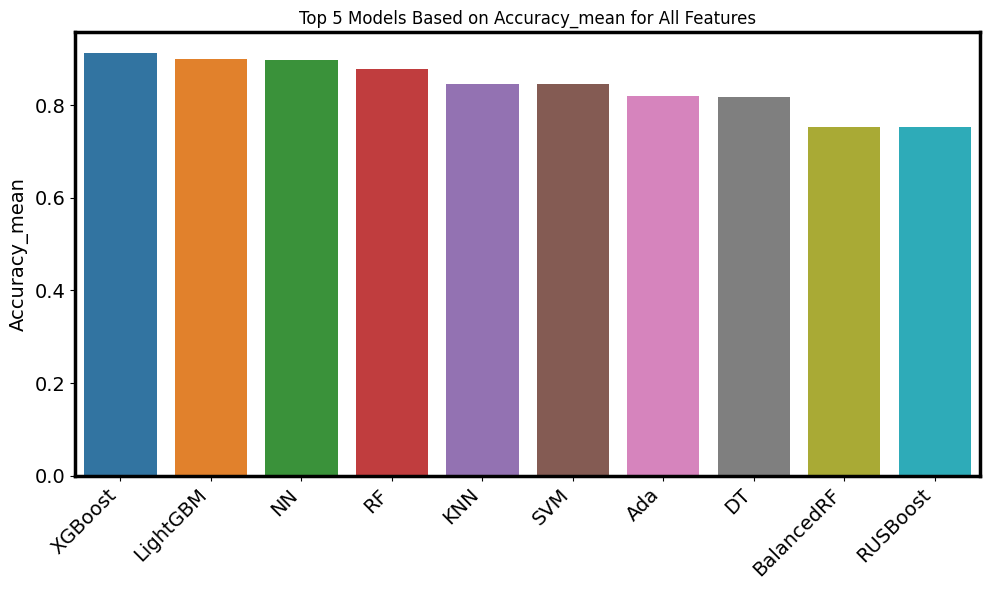

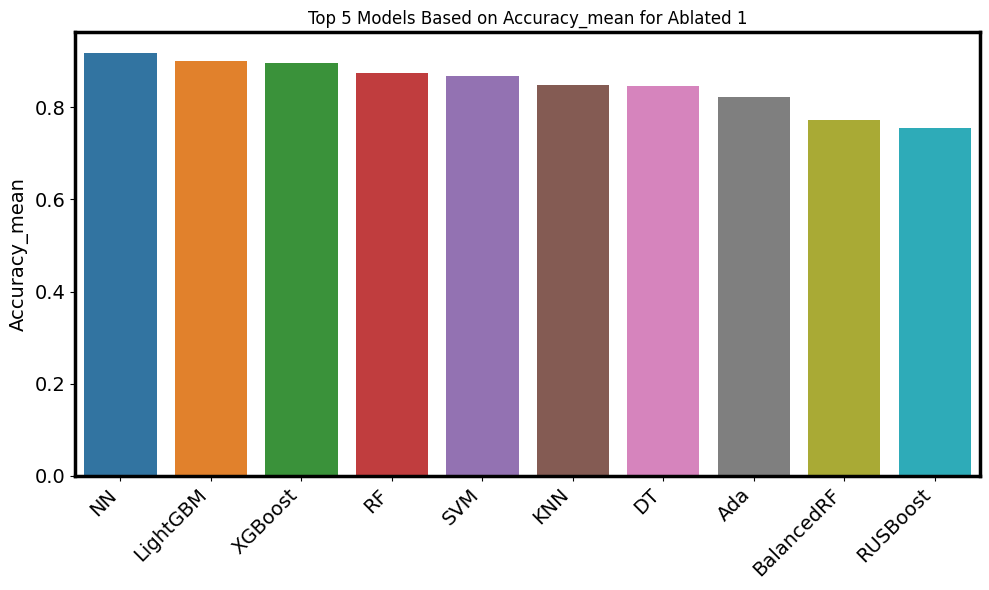

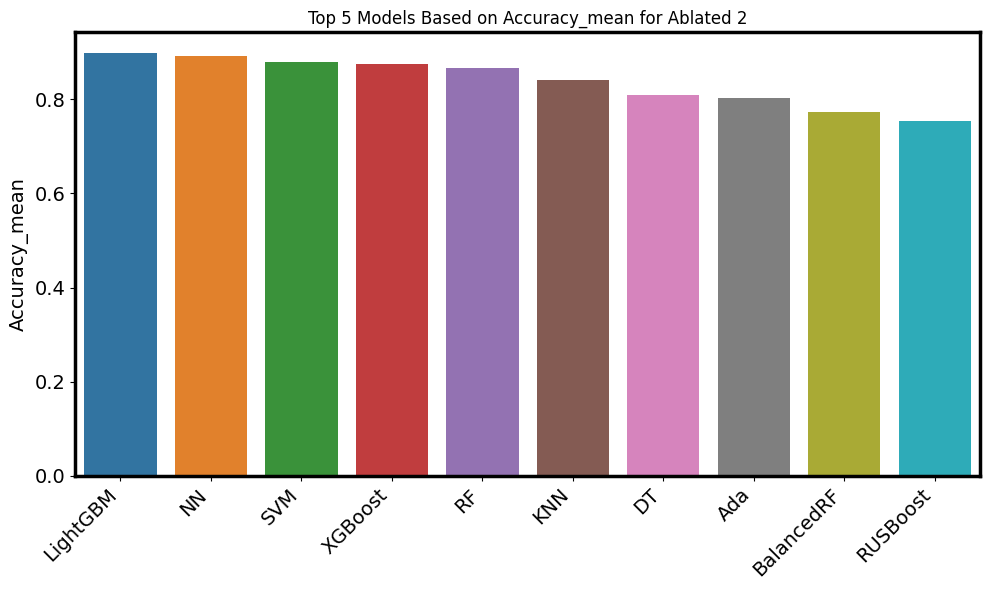

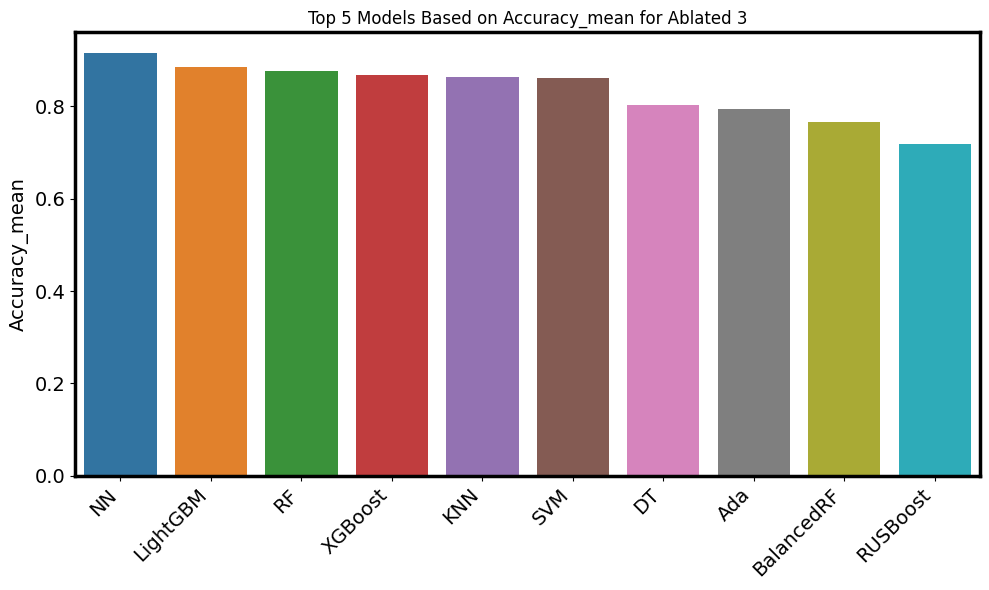

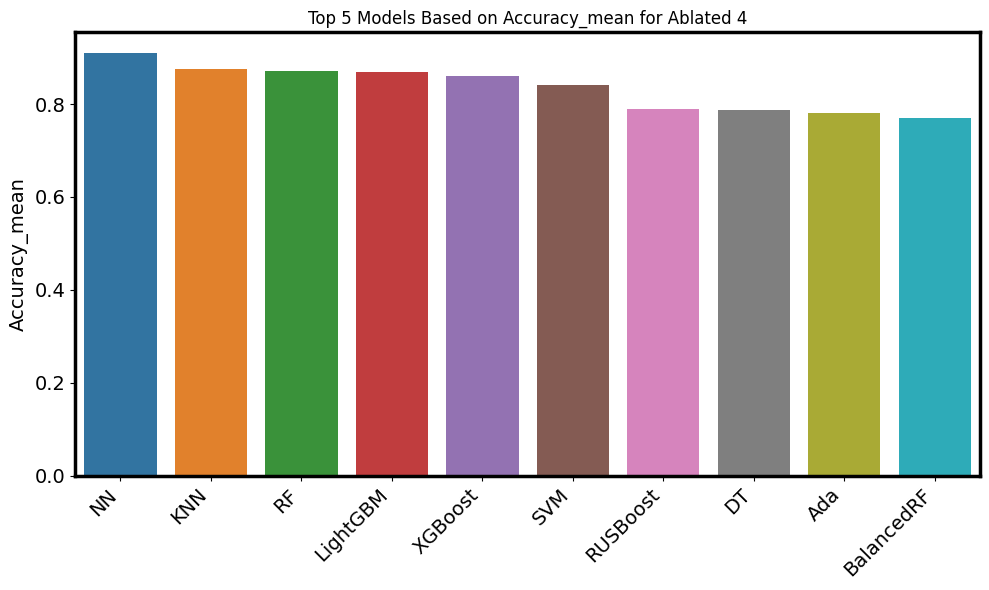

In [28]:
# Create bar charts for top 5 models based on 'Accuracy_mean'
create_bar_chart(final_results_df, 'Accuracy_mean')

In [25]:
# Function to create heatmaps
def create_heatmap(df, metric_mean, fontsize=16, title_pad=20, label_pad=15, figsize=(12, 8), 
                   colorbar_length=0.9, grid_thickness=0.6):
    # Extract the model names from the columns
    model_names = set(col.split('_')[0] for col in df.columns if '_' in col)
    
    # Create a dataframe suitable for heatmaps
    heatmap_df = pd.DataFrame(index=df['Dataset'], columns=model_names)
    for model in model_names:
        heatmap_df[model] = df[f"{model}_{metric_mean}"].values

    # Reorder the columns based on descending accuracy on the "All Features" dataset
    all_features_accuracy = heatmap_df.loc['All Features'].sort_values(ascending=False)
    heatmap_df = heatmap_df[all_features_accuracy.index]
    
    # Create the heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", fmt=".3f", linewidths=grid_thickness, 
                     linecolor='black', cbar_kws={"shrink": colorbar_length}, annot_kws={"size": fontsize-4})
    
    # Set title and labels with font sizes and paddings
    plt.title(f"Heatmap Based on {metric_mean}", fontsize=fontsize+6, pad=title_pad)
    plt.xlabel("Models", fontsize=fontsize+6, labelpad=label_pad)
    plt.ylabel("Datasets", fontsize=fontsize+6, labelpad=label_pad)
    plt.xticks(fontsize=fontsize, rotation=45, ha='right')
    plt.yticks(fontsize=fontsize, rotation=0, ha='right')

Saving figure metrics_heatmaps/Accuracy_heatmap.png
Saving figure metrics_heatmaps/F1 Score_heatmap.png
Saving figure metrics_heatmaps/Recall_heatmap.png
Saving figure metrics_heatmaps/Precision_heatmap.png
Saving figure metrics_heatmaps/ROC-AUC_heatmap.png
Saving figure metrics_heatmaps/Inference Time_heatmap.png
Saving figure metrics_heatmaps/Balling (Conduction)_heatmap.png
Saving figure metrics_heatmaps/Balling (LoF)_heatmap.png
Saving figure metrics_heatmaps/Balling (Overheating)_heatmap.png
Saving figure metrics_heatmaps/Laser-off_heatmap.png
Saving figure metrics_heatmaps/LoF_heatmap.png
Saving figure metrics_heatmaps/Non-defective_heatmap.png
Saving figure metrics_heatmaps/Overheating_heatmap.png


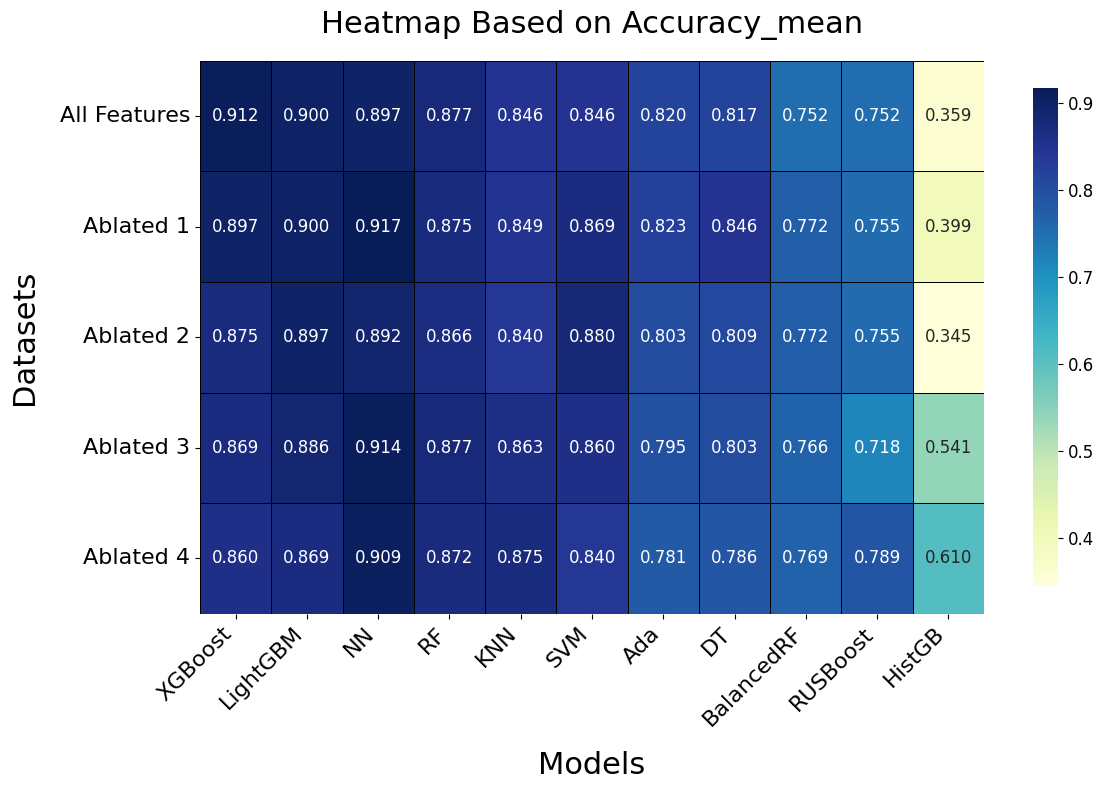

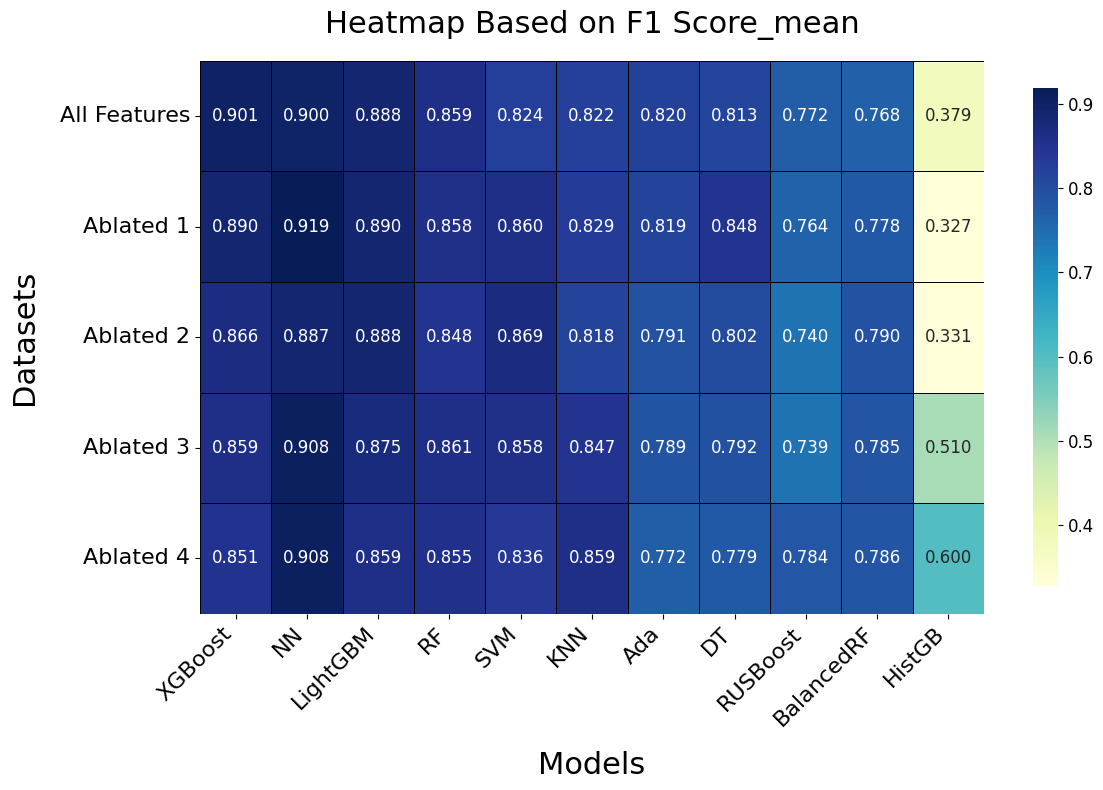

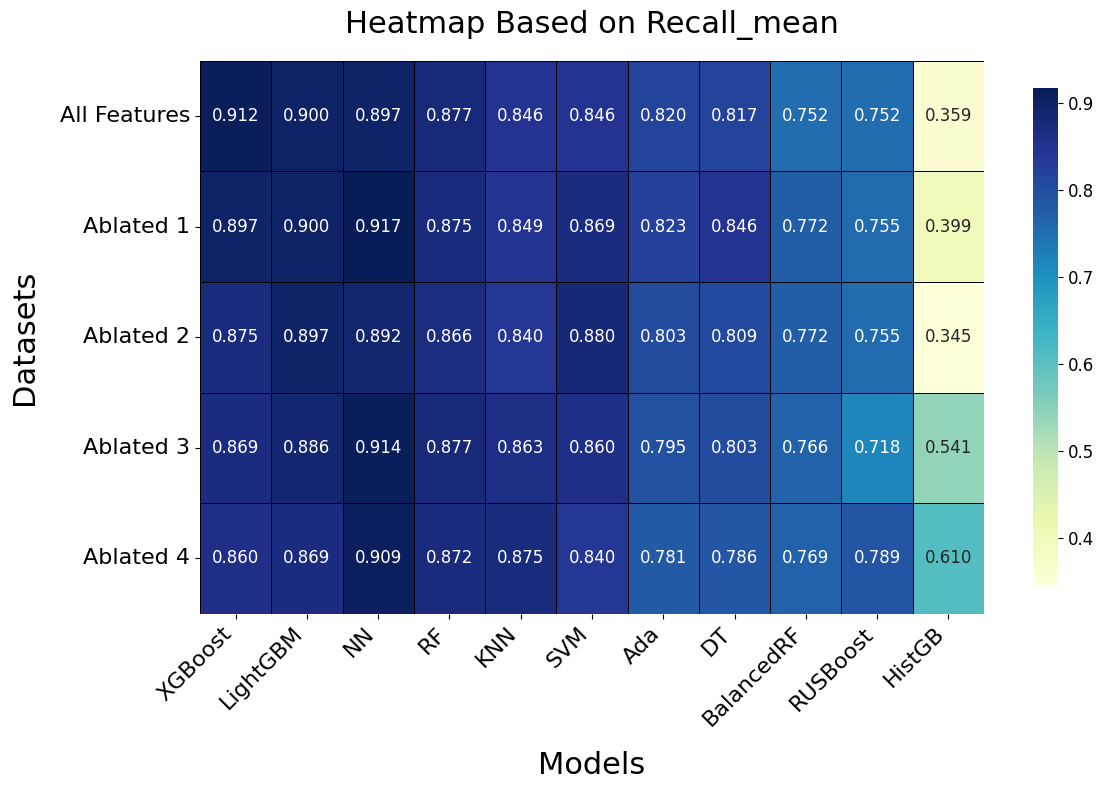

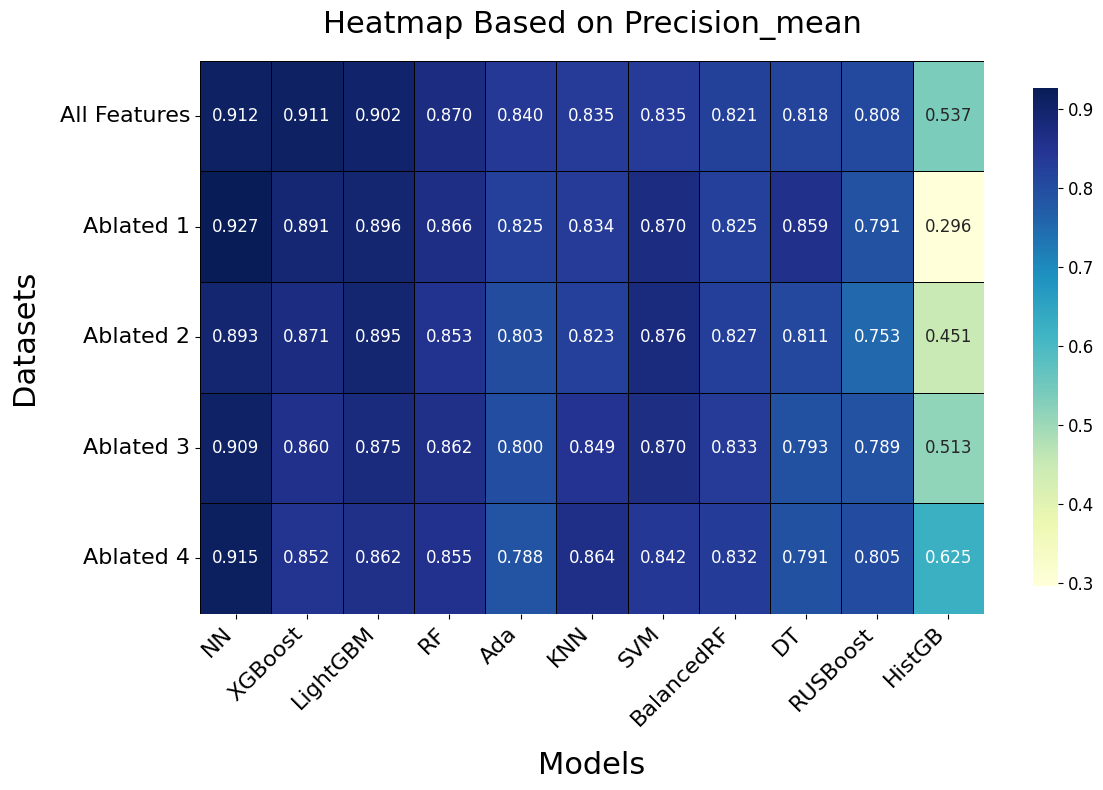

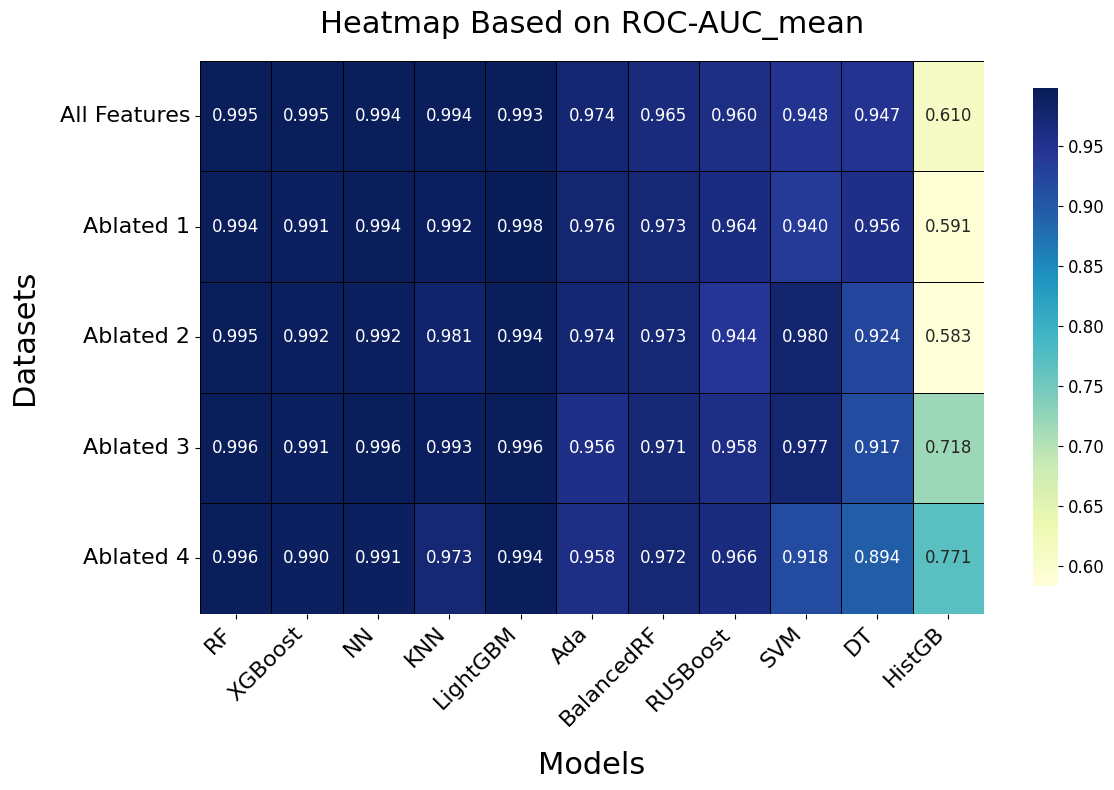

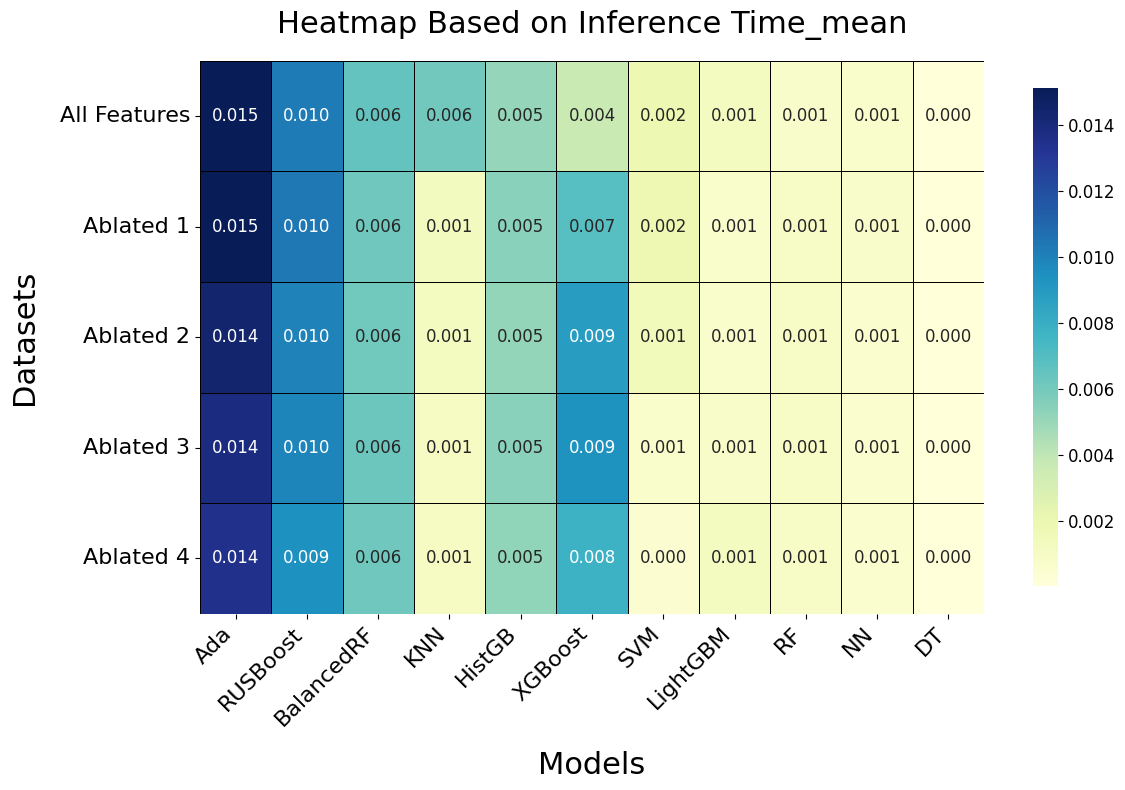

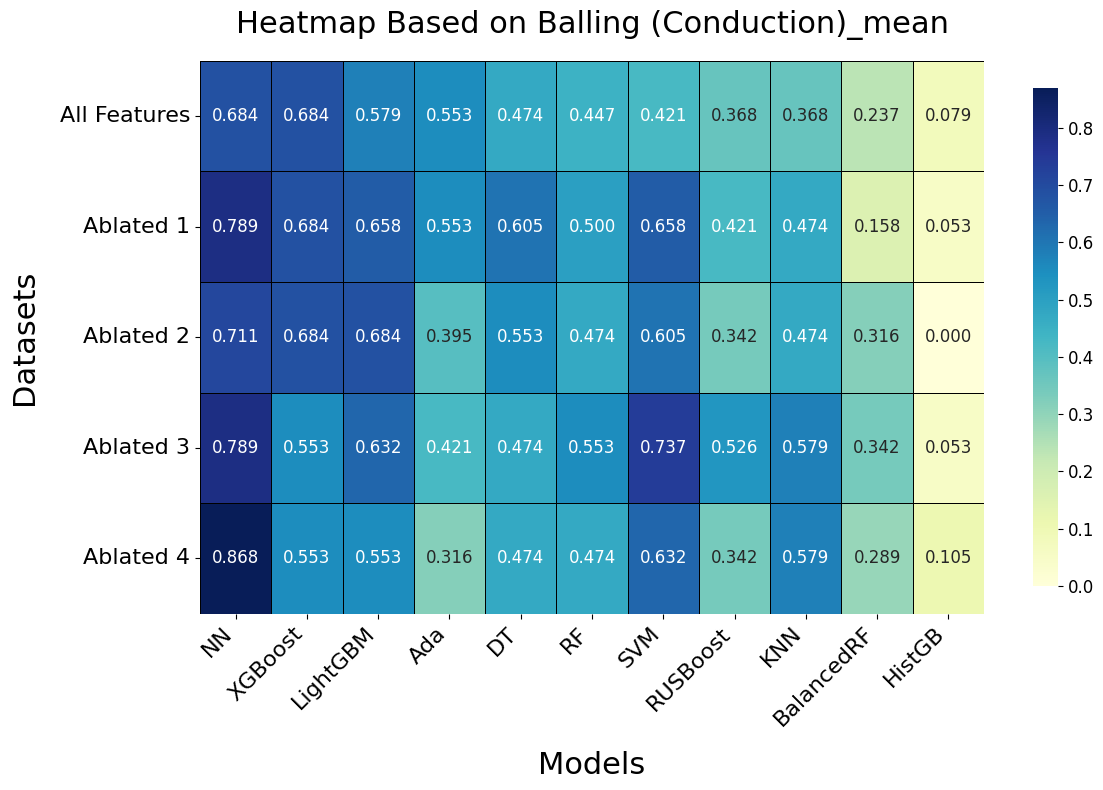

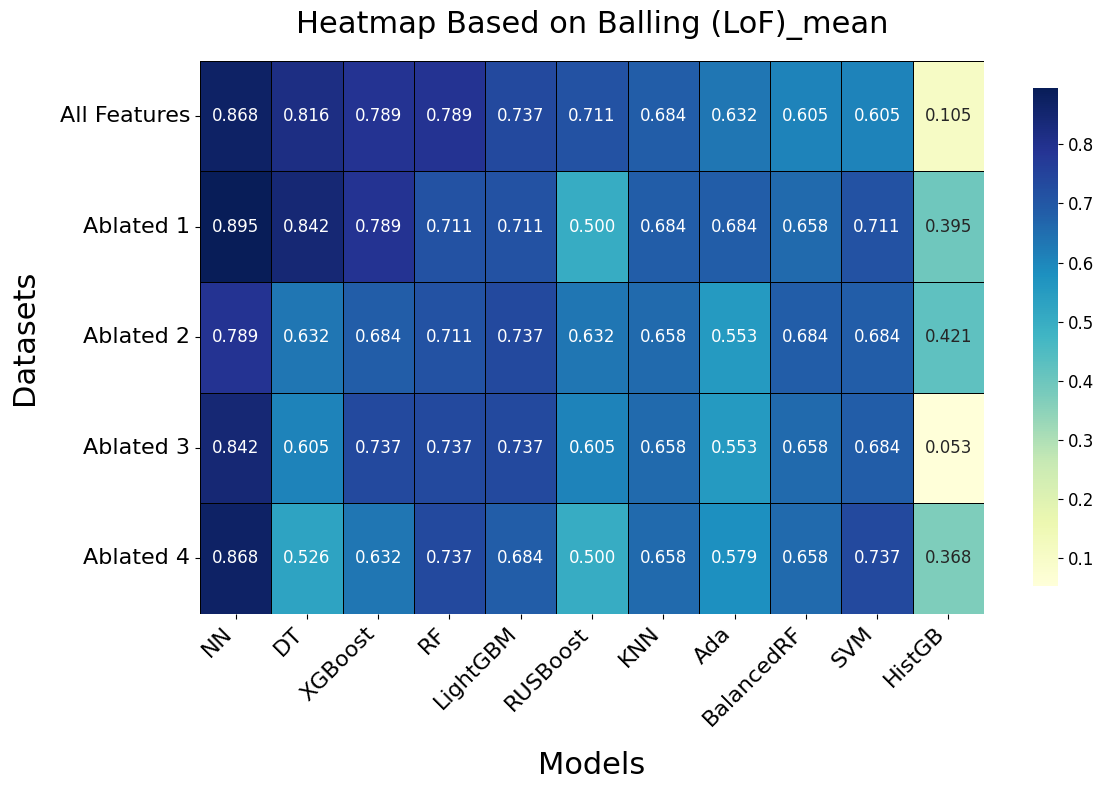

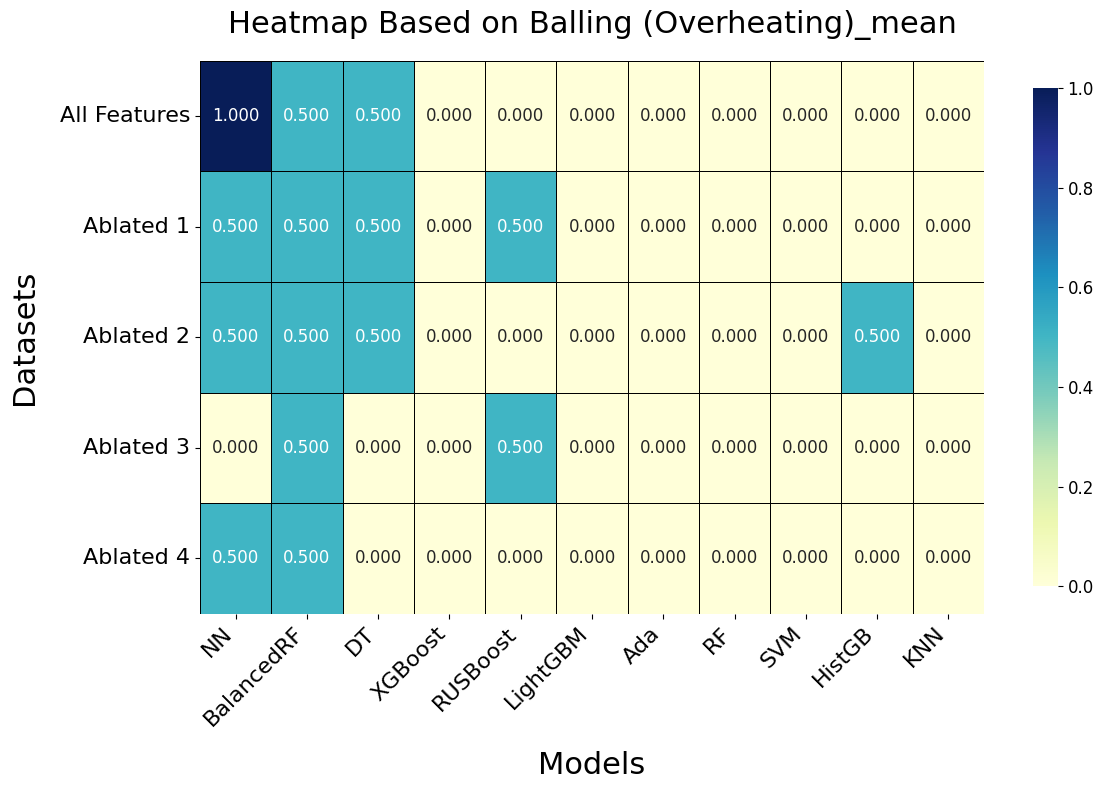

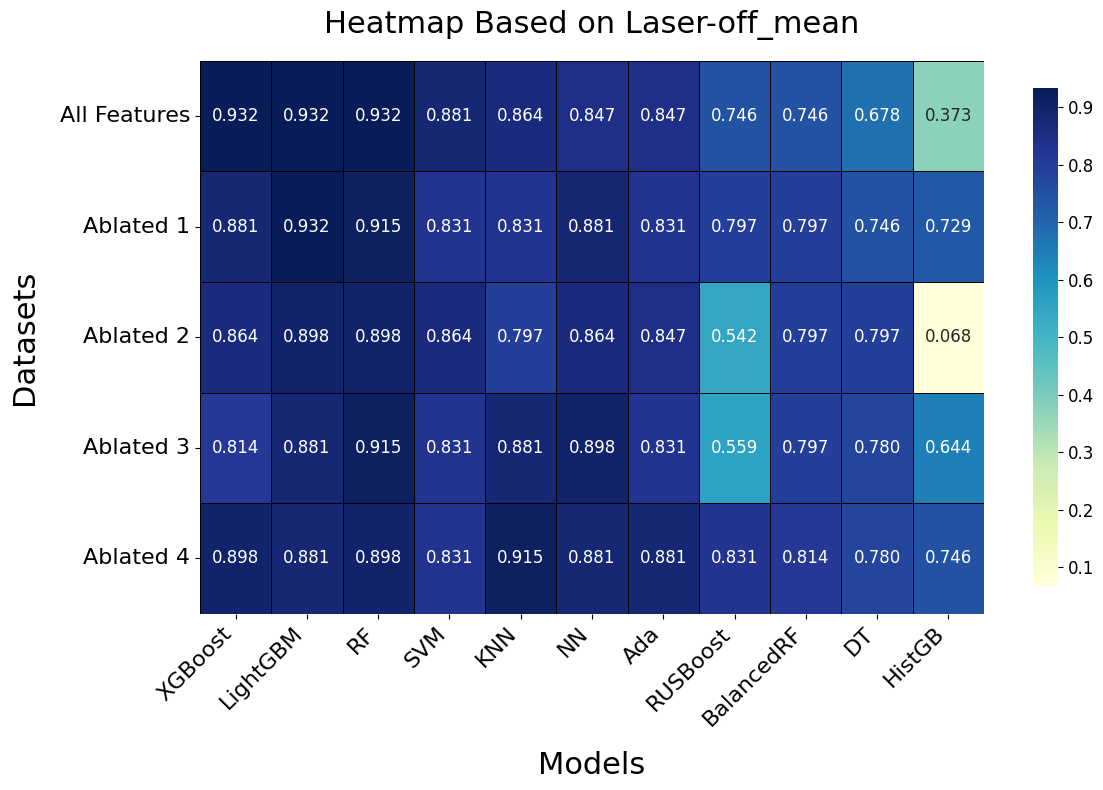

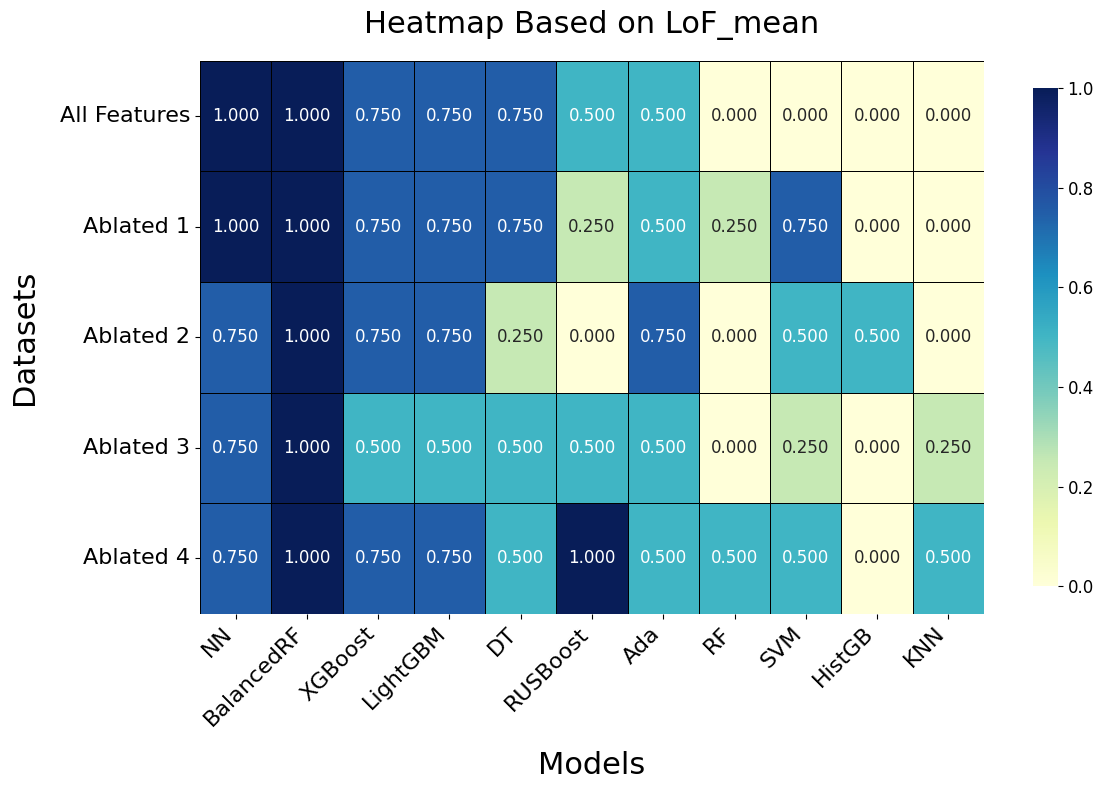

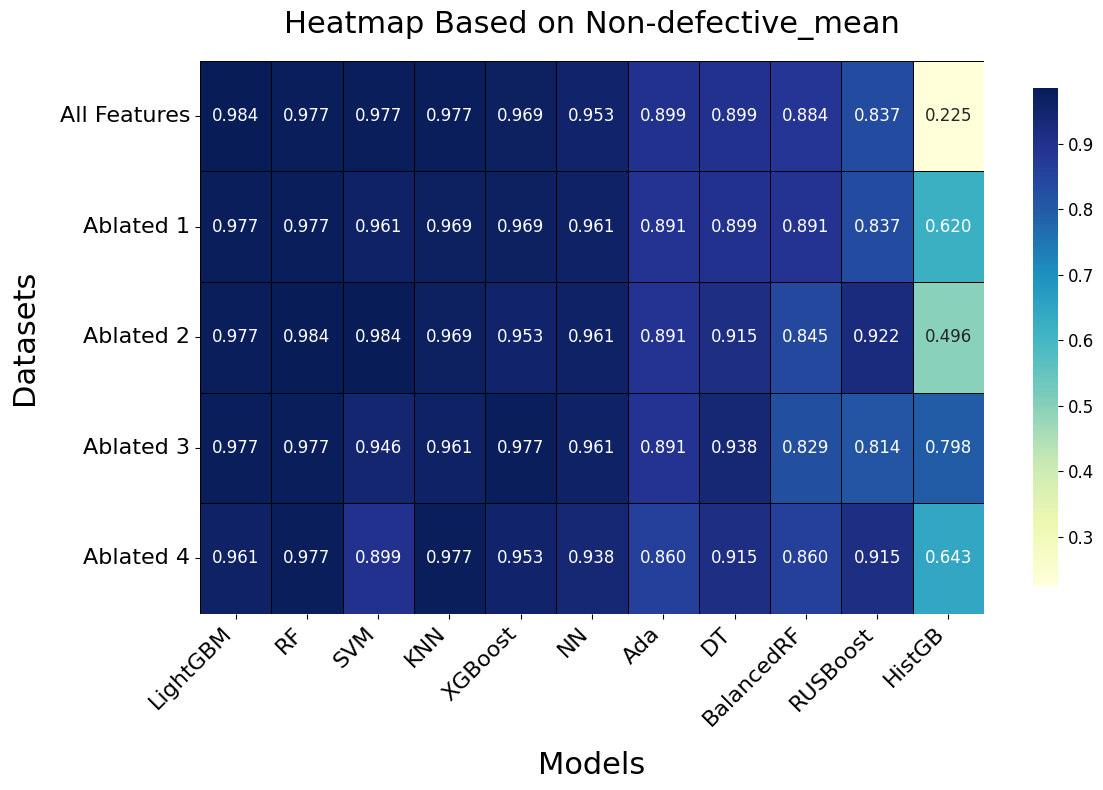

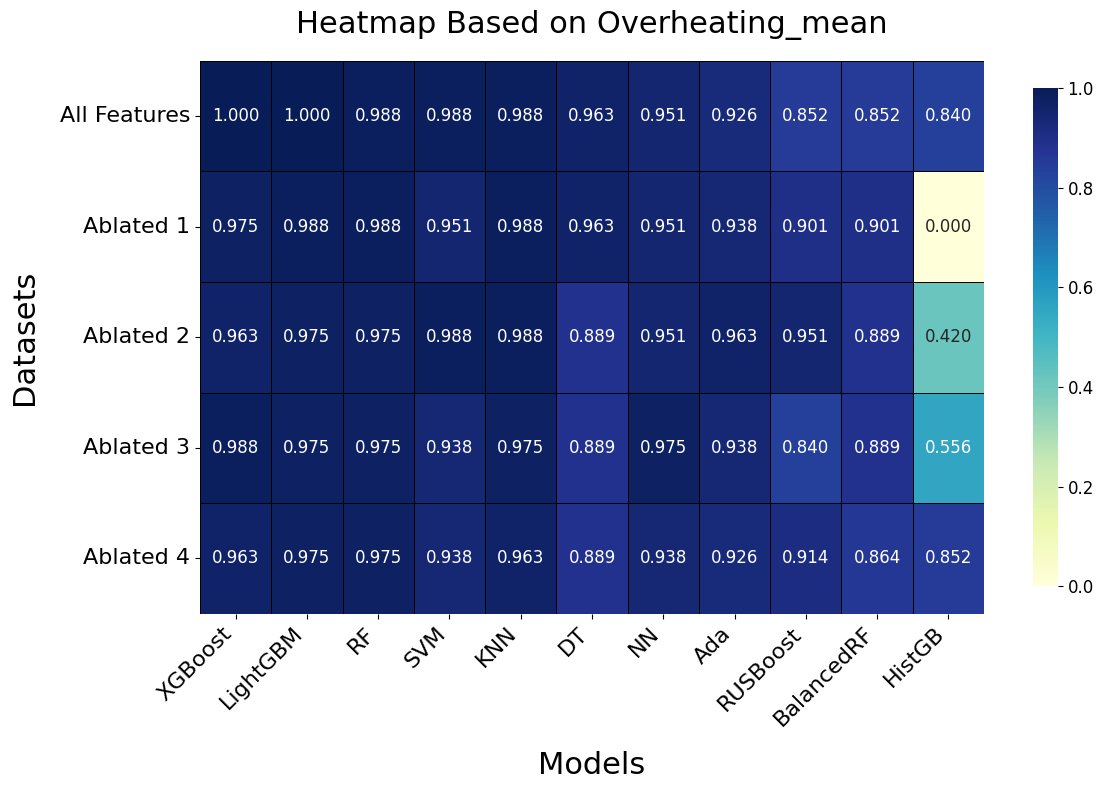

In [27]:
# Create a function to run create_heatmap for each evaluation metric and save the figure
def run_and_save_heatmaps(df, metrics, save_path, **kwargs):
    for metric in metrics:
        create_heatmap(df, f"{metric}_mean", **kwargs)
        save_fig(f"{save_path}/{metric}_heatmap.png")

# Uncomment the line below to run the function.
run_and_save_heatmaps(final_results_df, evaluation_metrics, save_path="metrics_heatmaps")